# Jupyter Notebook - Projet Banklytics
## Estimation de la Valeur des Biens Immobiliers

Version mise à jour inspirée des meilleures pratiques de preprocessing et d'optimisation.

Ce notebook suit la méthodologie du projet, de l'analyse à la soumission, en intégrant un pipeline Scikit-Learn robuste et une optimisation d'hyperparamètres avec Optuna.

Configuration de l'environnement et des différents imports

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FunctionTransformer

import xgboost as xgb
import optuna

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

Fonctions utilisées

In [121]:
# Display missing values
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

In [122]:
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted) :
    return np.sqrt(mean_squared_error(actual, predicted))

## 1. Phase d'Idéation : Compréhension du Contexte et des Données

In [123]:
# 1.1 Chargement des données
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print(f"Données d'entraînement chargées : {train_df.shape}")
    print(f"Données de test chargées : {test_df.shape}")
except FileNotFoundError:
    print("Erreur : Assurez-vous que les fichiers 'train.csv' et 'test.csv' sont présents.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()


Données d'entraînement chargées : (1460, 81)
Données de test chargées : (1459, 80)


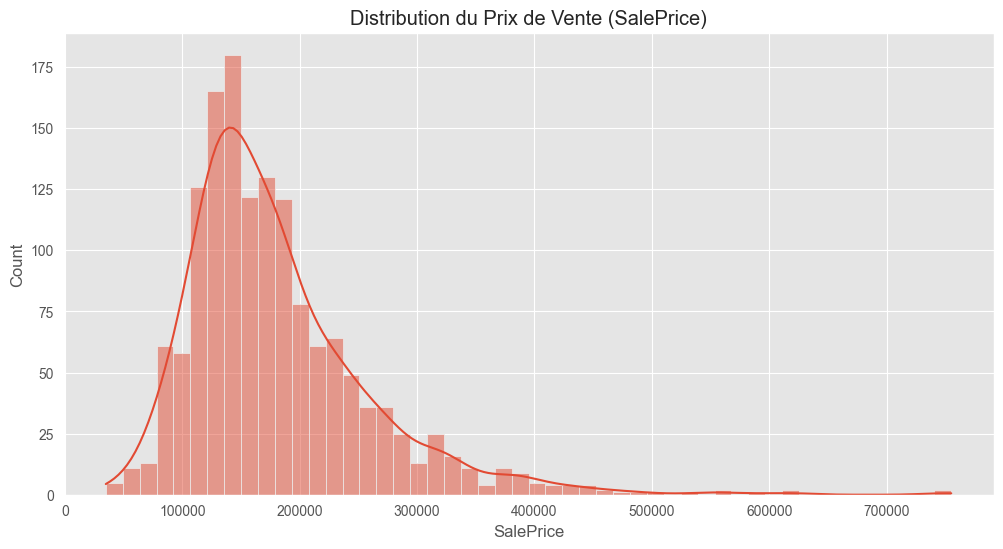

Asymétrie (Skewness) du prix de vente : 1.88
La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.


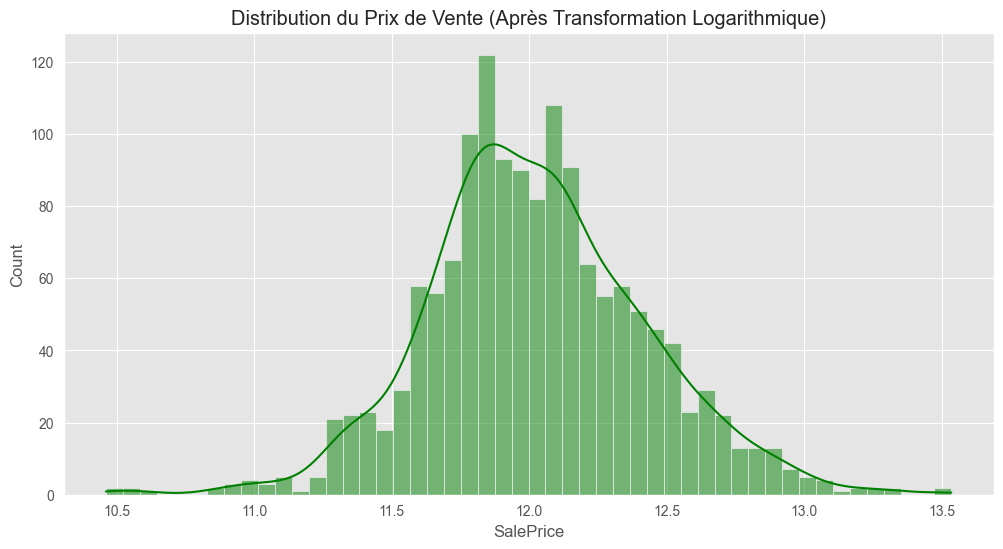

Asymétrie après transformation : 0.12


In [124]:
# 1.2 Analyse Exploratoire des Données (EDA)
if 'SalePrice' in train_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df['SalePrice'], kde=True, bins=50)
    plt.title('Distribution du Prix de Vente (SalePrice)')
    plt.show()
    print(f"Asymétrie (Skewness) du prix de vente : {train_df['SalePrice'].skew():.2f}")
    print("La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.")

    target = np.log1p(train_df["SalePrice"])

    plt.figure(figsize=(12, 6))
    sns.histplot(target, kde=True, bins=50, color='green')
    plt.title('Distribution du Prix de Vente (Après Transformation Logarithmique)')
    plt.show()
    print(f"Asymétrie après transformation : {target.skew():.2f}")

Il convient maintenant de nous intéresser de plus près aux données que nous avons à disposition afin de créer nos modèles. Nous allons dans un premier temps les diviser en trois catégories :
- Les données qualitatives
- Les données quantitatives
- Les dates



In [125]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

Une fois la catégorisation effectuée, nous avons controlé la qualité du dataset sur lequel nous allons entrainer nos modèles et certaines données sont manquantes ou alors non utilisables en l'état. Nous devons alors les nettoyer et les rendre utilisables par nos modèles. Afin de garder une cohérence, nous allons concaténer les données d'entrainements ainsi que les données de test pour être sur de traiter les données de la même manière.

Faisons dans un premier temps l'état des lieux des différentes valeurs que l'on pourrait qualifier de manquantes.

In [126]:
data_df = pd.concat([train_df, test_df])

Nombre de données quantitatives manquantes


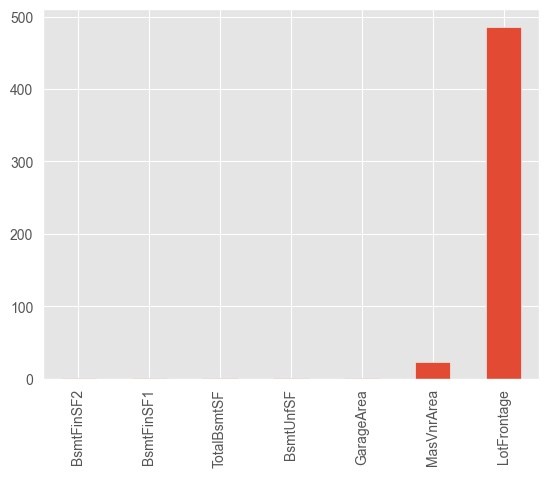

In [127]:
print(f"Nombre de données quantitatives manquantes")
plot_missing(data_df[quantitative])

Nombre de données qualitatives manquantes


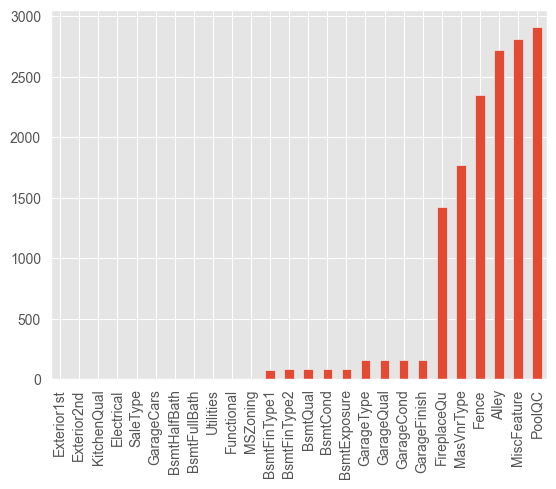

In [128]:
print(f"Nombre de données qualitatives manquantes")
plot_missing(data_df[qualitative])

Nombre de données dates manquantes


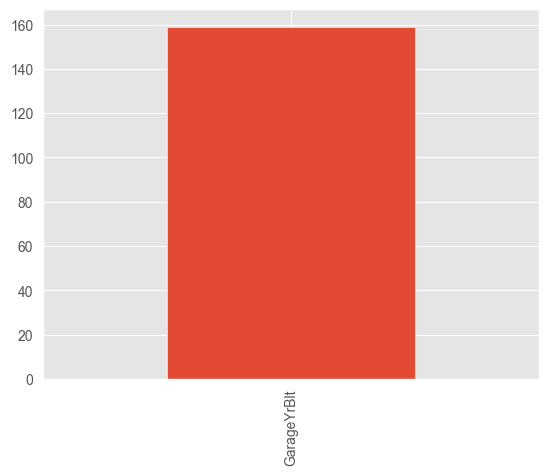

In [129]:
print(f"Nombre de données dates manquantes")
plot_missing(data_df[date])

Nous ne pouvons pas laisser ces données comme ça car elles seront inexploitable par le modèle. Par conséquent, en fonction du type de données nous allons devoir interpreter ce cela veut signifer. Par exemple, en ce qui concerne la donnée LotFrontage, NA signifie qu'il n'y a pas de rue collée à la propriété. Comme LotFrontage est une valeur quantitative, nous pouvons alors remplacé ce NA par 0 ce qui permettra au modèle de comprendre la donnée sans pour autant perdre l'information qu'elle représente.  
  
Certaines valeurs qualitatives comme GarageType ont également des données manquantes notées NA dans notre dataset cependant nous devons les traiter différemment puisqu'il s'agit de données qualitative. Nous avons décider de laisser NA pour toutes les données qualitatives et nous savons que cette notation n'indique pas l'absence de données (null) mais bien une information qui a été recensée.  
  
Concernant les colonnes de types date, seul GarageYrBlt contient des valeurs NA. Afin d'unifier cette donnée, nous avons décidé de remplacer par le valeur -1 qui consisteraient à indiquer l'absence de garage.

In [130]:
# Function to fill missing data with a constant value
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

In [131]:
def fill_missing_with_column(data, missing, column) :
    
    data_clean = data.copy()
    
    data_clean[missing] = np.where(data_clean[missing].isnull(), data_clean[column], data_clean[missing])
    
    return data_clean

Etant donné l'écart des années de ventes dans notre dataset, il nous faut convertir les différentes colonnes de dates (`YearBuilt`, `YearRemodAdd`, et `GarageYrBlt`) en durée afin d'unifier les durées entre l'année de vente et les différentes dates.

In [132]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

In [133]:
def clean(data) :
    
    data_clean = data.copy()
    
    # imputing missing variables
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_column(data_clean, missing = ['GarageYrBlt'], column = ['YearBuilt'])

    # transform date columns
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

In [134]:
data_clean_df = clean(data_df)
train_clean_df = clean(train_df)
test_clean_df = clean(test_df)

## Modèle Baseline et choix des variables pour ce dernier  

Afin de pouvoir créer un modèle Baseline simple, nous devons séléctionner les variables qui vont être le plus correlées avec le logarithme du prix de vente.  
  
Pour se faire, nous devons encoder les variables qualitatives en variable numériques afin de calculer leur corrélation. Une solution à ce problème serait de remplacer la variable par la moyenne de la variable cible associée. Ceci entrainera donc une correlation entre la variable qualitative et la nouvelle variable créée.

In [135]:
def encode_with_mean(data, target, features):
    
    data_preprocess = data.copy()
    
    for f in features: 
        
        # create a temporary dataframe for our workload
        frame = pd.DataFrame()
        frame[f] = data[f].copy()
        frame[target.name] = target.copy()
        
        # create the mapping table
        mapping = pd.DataFrame()
        mapping['val'] = data[f].unique()
        mapping.index = mapping.val
        
        # compute the mean of our target variable for each category
        mapping['mean'] = frame[[f, target.name]].groupby(f).mean()[target.name]
        
        # if a category has NA, we shall simply put the mean value
        mapping['mean'] = mapping['mean'].fillna(target.mean())

        # we replace the feature with the means in the mapping table
        data_preprocess[f] = pd.merge(data_preprocess, mapping, left_on = f, right_index = True)['mean'].copy()
        
    return data_preprocess

In [136]:
#Function to calculate the correlation of Pearson between a target variable and features
def correlation(y, X, features, method = 'pearson'):
    
    cor = pd.DataFrame()
    cor['feature'] = features
    
    cor['correlation_coef'] = [X[f].corr(y, method = method) for f in features]
    cor['correlation_coef'] = cor['correlation_coef'].fillna(0)
    cor['correlation_coef_abs'] = cor['correlation_coef'].abs()
    
    cor = cor.sort_values('correlation_coef', ascending = False)

    plt.figure(figsize=(10, 0.25*len(features)))
    sns.barplot(data = cor, y = 'feature', x = 'correlation_coef', orient = 'h')
    
    return cor

,feature,correlation_coef,correlation_coef_abs
56,OverallQual,0.817185,0.817185
9,Neighborhood,0.755518,0.755518
66,GrLivArea,0.700927,0.700927
44,GarageCars,0.700078,0.700078
19,ExterQual,0.679060,0.679060
...,...,...,...
65,LowQualFinSF,-0.037963,0.037963
70,EnclosedPorch,-0.149050,0.149050
76,YearRemodAdd,-0.568136,0.568136
78,GarageYrBlt,-0.569568,0.569568


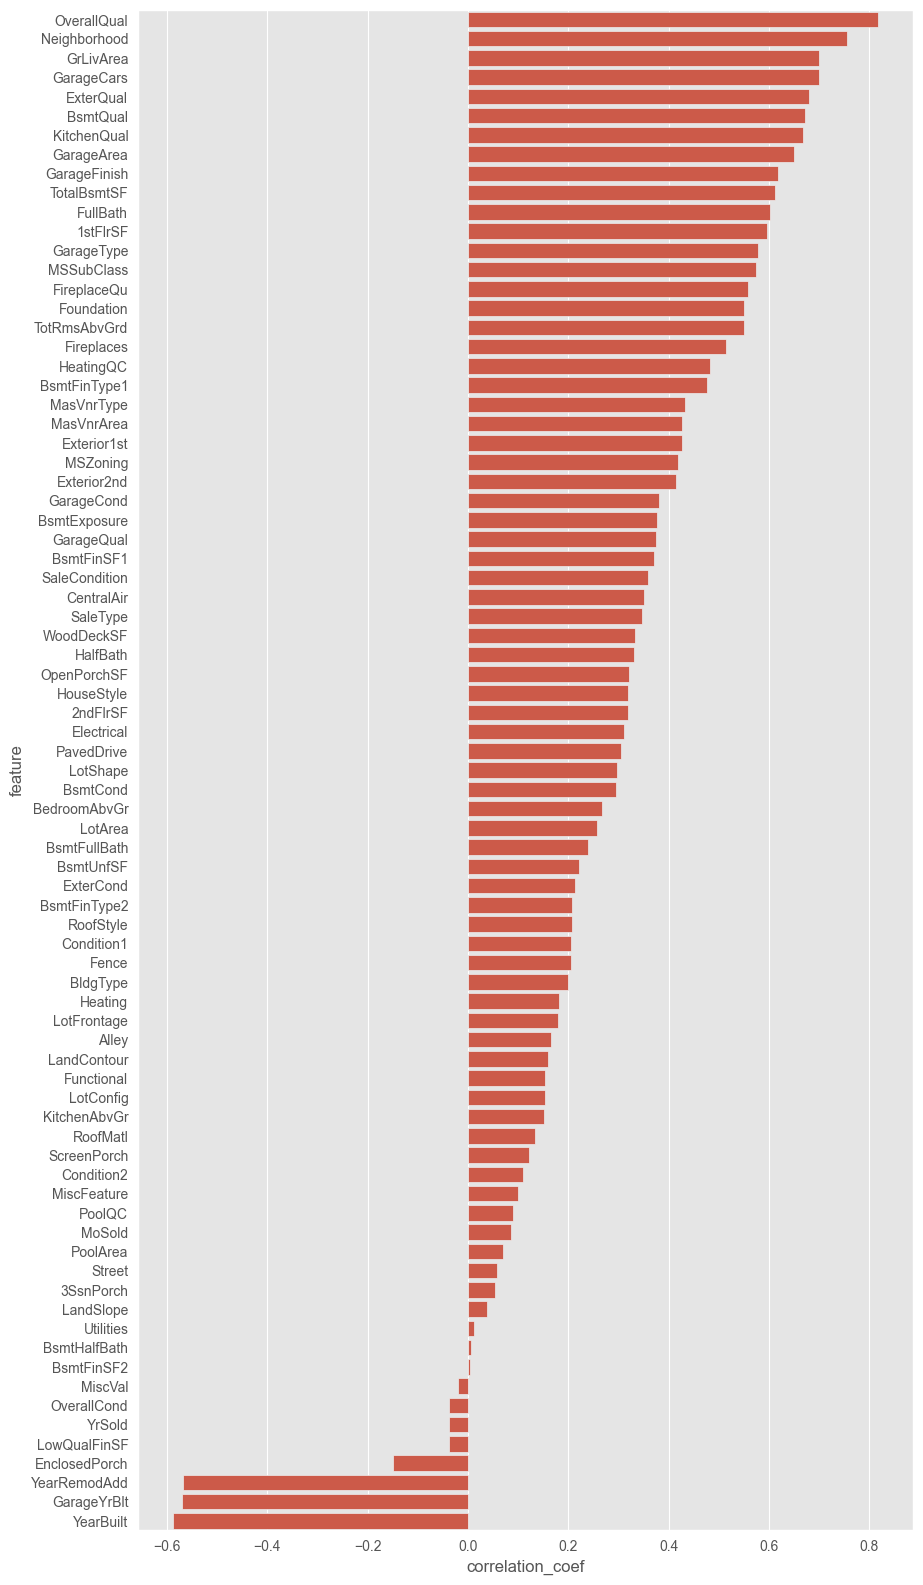

In [137]:
data_preprocess = encode_with_mean(data_clean_df, target, qualitative)

# Split of the clean dataset into train & validation
train_preprocess = encode_with_mean(train_clean_df, target, qualitative)
validation_preprocess = encode_with_mean(test_clean_df, target, qualitative)

cor = correlation(target, train_preprocess, qualitative + quantitative + date)
cor

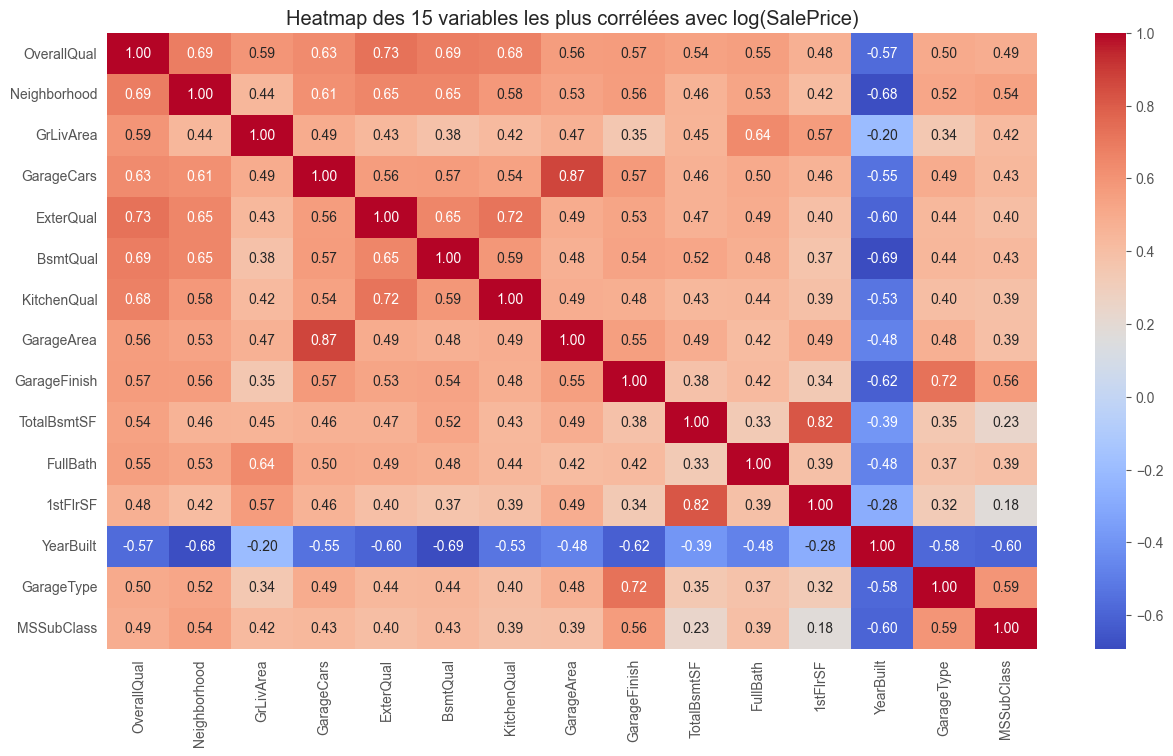

In [138]:
# Sélectionne les 10 variables avec la plus forte corrélation absolue
top15 = cor.sort_values('correlation_coef_abs', ascending=False).head(15)['feature'].tolist()
# Sous-ensemble du DataFrame train_preprocess avec ces variables
df_top10 = train_preprocess[top15]

# Affiche la heatmap de corrélation
plt.figure(figsize=(15, 8))
sns.heatmap(df_top10.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap des 15 variables les plus corrélées avec log(SalePrice)")
plt.show()

Nous allons donc séléctionner cinq variables afin de créer notre baseline. D'après les données de correlations ci-dessus ainsi que notre compréhension du métier et du domaine immobilier, les variables suivantes ont retenues notre attention.  
- `OverallQual`, correlation de 0.82
- `Neighborhood`, correlation de 0.76
- `GrLivArea`, correlation de 0.70
- `TotalBsmtSF`, correlation de 0.61
- `YearBuilt`, correlation de -0.59

Ces variables sont assez communes lors de la recherche d'un logement et représentent plus ou moins les critères de bases. En ce qui concerne la cave, il s'agit d'un point assez essentiel au vu de la situation géographique de Ames car elle se situe en plein milieu du couloir des tornades (zone géographique des États-Unis fréquemment touchée par ce phénomène).
  
Notre baseline reposera donc sur ces cinq variables et nous appliqueronns la regréssion linéaire afin de faire notre modèle.

In [139]:
base = ['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']


x = train_preprocess[base]
y = target


model = sm.OLS(y, sm.add_constant(x))
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1367.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:11:39   Log-Likelihood:                 539.40
No. Observations:                1460   AIC:                            -1067.
Df Residuals:                    1454   BIC:                            -1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8392      0.271     25.244   

Voici les assomptions pour la régression linéaire, en indiquant avec quel graphique nous allons les tester :
- Linéarité de la relation entre les variables explicatives et la variable cible -> Residuals vs Fitted
- Les résultats sont normalements distribués autour de 0 -> Normal Q-Q Plot
- Homoscédasticité des résidus (variance constante) -> Scale-Location Plot
- Absence de points influents démesurés -> Residuals vs Leverage
- Absence d'outliers dans les résidus (erreurs extrêmes) -> visible dans plusieurs graphes, notamment Q-Q Plot et Cook’s Distance

In [140]:
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]))
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals')
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]))
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]))
    
    plot_lm_4 = plt.figure()
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]))
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right')

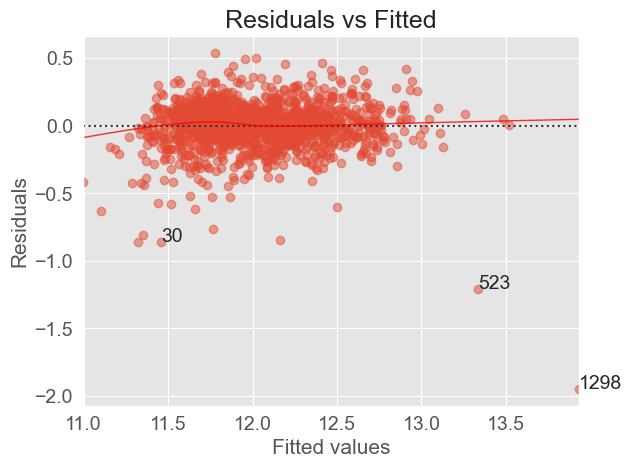

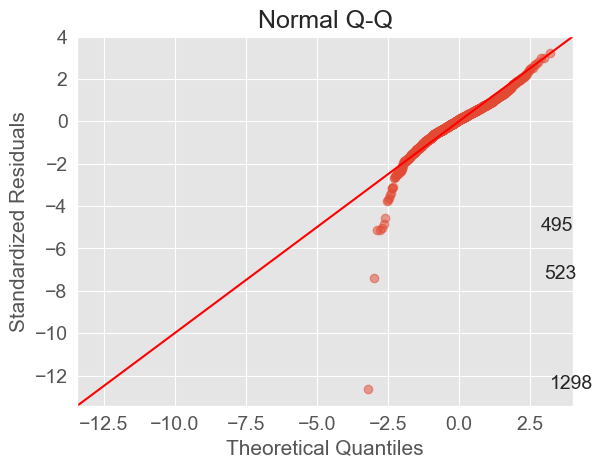

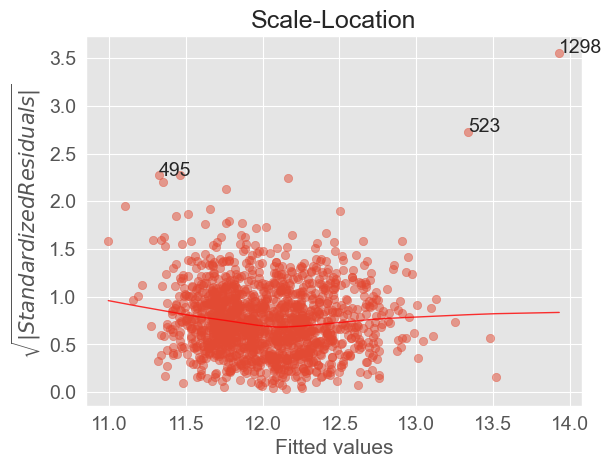

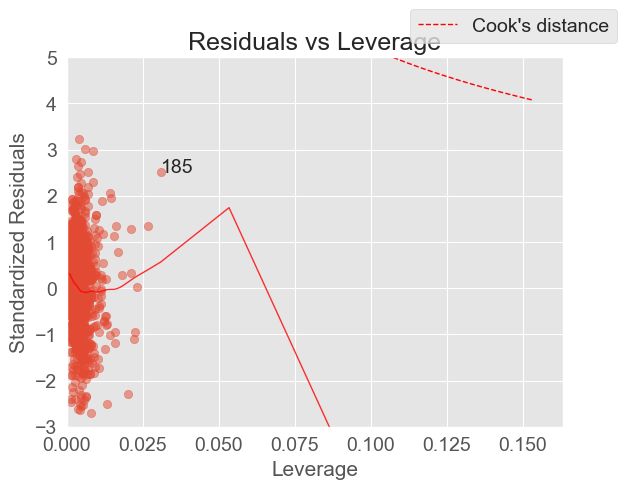

In [141]:
diagnostic_plots(sm.add_constant(x), y)

Nous voyons qu'il existe quelques valeurs extrêmes que les graphes ci-dessus ont mis en lumière. Il convient de les traiter afin qu'ils ne pejorent pas notre modèle. Un des critères sur lequel se baser pour éliminer une partie des ces valeurs extrêmes est la taille de la maison. En effet, par convention, les biens ayant une superficie habitable de plus de 4000 pieds carré sont extrêmement rares et ne sont pas représentatifs du marché.

Nous supprimons donc ces données extrêmes.

In [142]:
print(train_df[base].iloc[[185, 495, 523, 1298]])

      OverallQual Neighborhood  GrLivArea  TotalBsmtSF  YearBuilt
185            10      OldTown       3608         1107       1892
495             4       IDOTRR        720          720       1920
523            10      Edwards       4676         3138       2007
1298           10      Edwards       5642         6110       2008


In [143]:
def remove_outliers(data, target, feature):
    
    data_preprocess = data.copy()
    data_preprocess[target.name] = target.copy()
    
    #Compute interquartile range
    q1 = data_preprocess[feature].quantile(0.25)
    q3 = data_preprocess[feature].quantile(0.75)
    
    iqr = q3-q1 
    
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    data_preprocess = data_preprocess.loc[(data_preprocess[feature] > fence_low) & (data_preprocess[feature] < fence_high)]
    
    return data_preprocess[data.columns], data_preprocess[target.name]

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1522.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:11:40   Log-Likelihood:                 659.93
No. Observations:                1429   AIC:                            -1308.
Df Residuals:                    1423   BIC:                            -1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.7556      0.257     30.195   

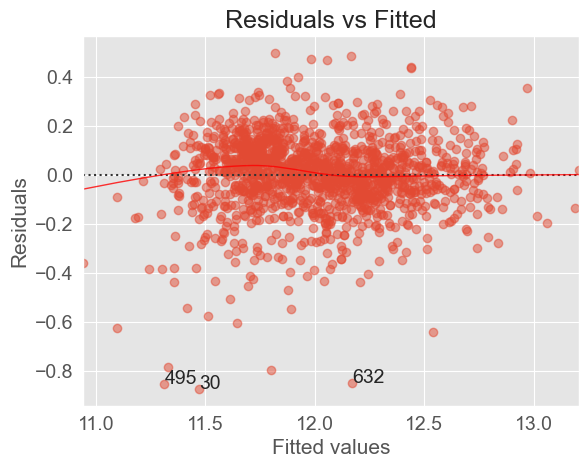

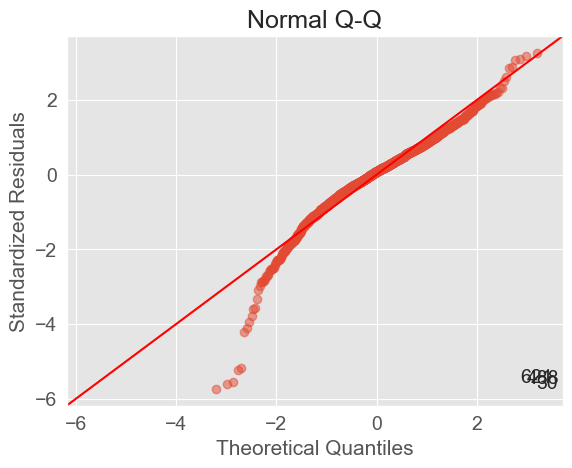

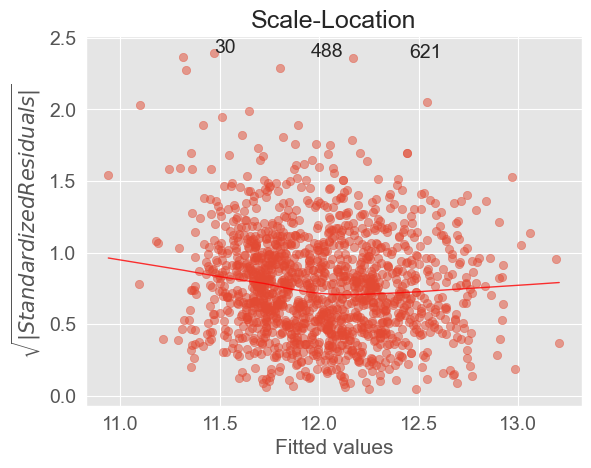

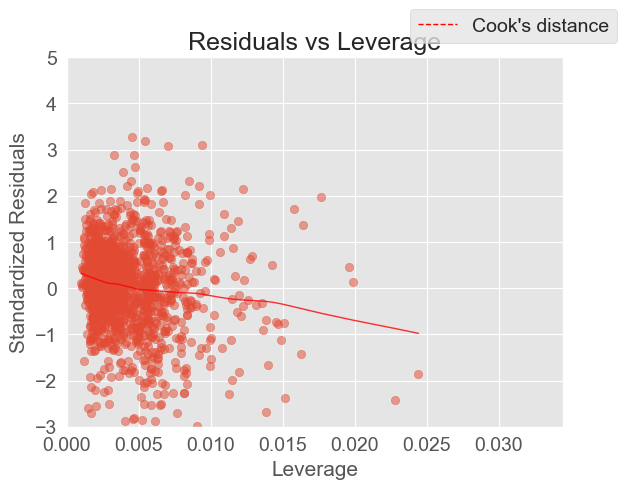

In [144]:
X, y = remove_outliers(x, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

Notre modèle semble mieux se comporter sans ces valeurs extrêmes. Il semble être convaincant pour notre baseline. Nous allons donc calculer le RMSE basé sur notre target (le log de SalePrice)

In [145]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

0    12.214534
1    12.081588
2    12.244451
3    12.046219
4    12.620316
dtype: float64


In [146]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.1524750806291098


## 2. Phase de Design : Ingénierie des Données et Pipeline de Modélisation

In [147]:
# Séparation des features (X) et de la cible (y)
if 'SalePrice' in train_df.columns:
    X = train_df.drop('SalePrice', axis=1)
    y = train_df['SalePrice']
    X_test = test_df.copy()

# Ingénierie des Features
all_data = pd.concat([X, X_test], axis=0)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.5].index
lam = 0.15
for feat in skewed_feats:
    all_data[feat] = boxcox1p(all_data[feat], lam)

X = all_data.iloc[:len(y)]
X_test = all_data.iloc[len(y):]

In [ ]:
# Pipelines de prétraitement
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)



Afin de s'assurer que nos données puissent être comprises et utilisées par notre modèle, il est primordial de créer une pipeline capable d'effectuer les transformations nécessaires de manières justes et systématiques.  

Dans notre cas, nous avons identifié trois types de données différents, les données quantitatives, les données qualitatives et les dates ou données temporelles. Il nous faudra donc créer des ColumnTransformer pour chacune de ces trois catégories.  

Il nous faudra également s'assurer de la qualité de nos données et ainsi "combler" les valeurs manquantes.
- Pour les valeurs quantitative, nous avons utilisé la stratégie de la médiane
- Pour les valeurs qualitative, nous avons utilisé la stratégie dite "Most frequent"

-- Parler du One-Hot encoder

Enfin, il nous a fallu gérer les valeurs extrêmes, liées à GrLivArea, pour ça nous allons donc retiré les valeurs à l'aide de la fonction défini plus haut

In [ ]:
#Pipeline de prétraitement
#Gestion des dates, transformation en durées relatives
def compute_relative_dates(df):
    df = df.copy()
    df['YearsSinceBuilt'] = df['YrSold'] - df['YearBuilt']
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['YearsSinceGarage'] = df['YrSold'] - df['GarageYrBlt'].fillna(df['YearBuilt'])
    return df[['YearsSinceBuilt', 'YearsSinceRemod', 'YearsSinceGarage']]

date_transformer = Pipeline(steps=[
    ('relativedates', FunctionTransformer(compute_relative_dates, validate=False))
])

#Gestion des valeurs qunantitatives manquantes (median)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

#Gestion des valeurs qualitatives manquantes (most_frequent) et encodage one-hot

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Assemblage des transformations dans un préprocesseur

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, quantitative),
    ('cat', categorical_transformer, qualitative),
    ('dates', date_transformer, date)
], remainder='drop')

X_train = train_df.copy()
X_test = test_df.copy()
y_train = target.copy()

#Suppression des valeurs extrêmes

outliers_ids = train_df.index[(train_df['GrLivArea'] > 4000)]

X_train = X_train.drop(index=outliers_ids)
y_train = y_train.drop(index=outliers_ids)

#Pipeline finale

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

preprocessing_pipeline

print(f"Nombre d'observations avant suppression des outliers : {train_df.shape[0]}")
print(f"Nombre d'observations après suppression : {X_train.shape[0]}")
print(f"Outliers supprimés : {len(outliers_ids)}")

Nombre d'observations avant suppression des outliers : 1460
Nombre d'observations après suppression : 1456
Outliers supprimés : 4


## 3. Phase de Validation : Optimisation des Hyperparamètres avec Optuna

In [149]:
print("\n--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(full_pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print(f"\nMeilleur score RMSLE (validation croisée): {study.best_value:.5f}")
print("Meilleurs hyperparamètres trouvés:")
print(study.best_params)

optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

[I 2025-06-23 22:11:40,902] A new study created in memory with name: no-name-2640ab3f-f68c-4b55-8f44-bb43999e0a9e



--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---


[I 2025-06-23 22:12:04,255] Trial 0 finished with value: 29201.819140625 and parameters: {'n_estimators': 3243, 'learning_rate': 0.03142587578150192, 'max_depth': 9, 'subsample': 0.5811091214977773, 'colsample_bytree': 0.6909585575173467, 'reg_alpha': 0.01977282936966086, 'reg_lambda': 8.044137515497267e-08}. Best is trial 0 with value: 29201.819140625.
[I 2025-06-23 22:12:16,634] Trial 1 finished with value: 31024.18984375 and parameters: {'n_estimators': 2363, 'learning_rate': 0.048595283778887464, 'max_depth': 7, 'subsample': 0.9638475087495629, 'colsample_bytree': 0.8161324482716202, 'reg_alpha': 4.623836152060525e-08, 'reg_lambda': 1.8796395873407868e-08}. Best is trial 0 with value: 29201.819140625.
[I 2025-06-23 22:12:22,965] Trial 2 finished with value: 29643.647265625 and parameters: {'n_estimators': 1371, 'learning_rate': 0.057525449299429904, 'max_depth': 6, 'subsample': 0.9376776015875623, 'colsample_bytree': 0.9639521003658627, 'reg_alpha': 2.6414359715971373e-07, 'reg_lam


Meilleur score RMSLE (validation croisée): 27057.20156
Meilleurs hyperparamètres trouvés:
{'n_estimators': 2749, 'learning_rate': 0.025301576392978684, 'max_depth': 4, 'subsample': 0.7675510634014583, 'colsample_bytree': 0.5591774965761115, 'reg_alpha': 3.091305250116647e-08, 'reg_lambda': 0.00030420024326068896}


## 4. Phase de Déploiement : Entraînement final et Prédiction

In [150]:
print("\n--- Entraînement du modèle final sur l'ensemble des données d'entraînement ---")

final_model = xgb.XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_model)
])
final_pipeline.fit(X, y)
print("Entraînement terminé.")

log_predictions = final_pipeline.predict(X_test)
final_predictions = np.expm1(log_predictions)

submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_predictions})
submission.to_csv('submission_optimized.csv', index=False)

print("\nFichier 'submission_optimized.csv' généré avec succès.")
print("Aperçu des prédictions :")
print(submission.head())


--- Entraînement du modèle final sur l'ensemble des données d'entraînement ---
Entraînement terminé.

Fichier 'submission_optimized.csv' généré avec succès.
Aperçu des prédictions :
     Id  SalePrice
0  1461        inf
1  1462        inf
2  1463        inf
3  1464        inf
4  1465        inf


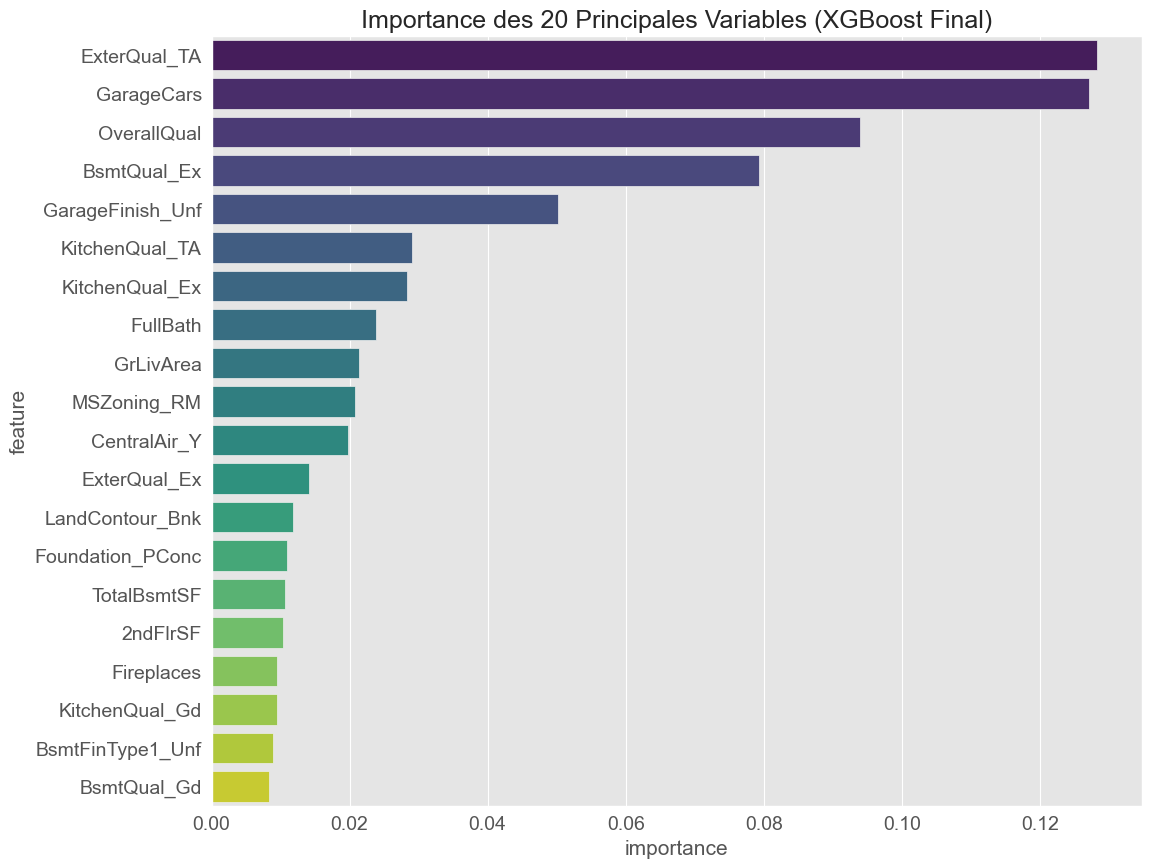

In [151]:
# 4.3 Analyse de l'Importance des Variables
ohe_feature_names = final_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('Importance des 20 Principales Variables (XGBoost Final)')
plt.show()

## Conclusion

Ce notebook a appliqué une démarche robuste et moderne :

1. Utilisation d'un pipeline Scikit-Learn pour un prétraitement propre et reproductible.
2. Optimisation automatisée des hyperparamètres avec Optuna pour maximiser la performance.
3. Entraînement d'un modèle final performant et génération des prédictions.
4. Analyse de l'importance des variables pour une meilleure explicabilité du modèle.

Le modèle est prêt à être intégré comme outil d'aide à la décision pour les analystes de Banklytics.